# EX_02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm 
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import math

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [2]:
# Simulation parameters
N = 1024
L = 6e-3  # 6 mm
dx = L / N
wavelength = 633e-9
k = 2 * np.pi / wavelength
f = 3.0  # focal length of all lenses

# Spatial and frequency grids
x = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, x)
fx = np.fft.fftfreq(N, dx)
FX, FY = np.meshgrid(fx, fx)

In [ ]:
def fqpm_mask_2d(N):
    mask = np.ones((N, N), dtype=complex)
    mask[:N//2, :N//2] *= -1  # top-left: π
    mask[N//2:, N//2:] *= -1  # bottom-right: π
    return mask



def angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)
        
    return U_list

def tilted_gaussian_beam(x, y, k, angle_x=0.0, angle_y=0.0, center=(0, 0), w0=0.5e-3):
    x0, y0 = center
    r2 = (x - x0)**2 + (y - y0)**2
    envelope = np.exp(-r2 / w0**2)
    phase = np.exp(1j * k * (x * np.sin(angle_x) + y * np.sin(angle_y)))
    return envelope * phase



def coronagraph2(angle_star=0.0, angle_planet=0.0, alpha=1.0, focal_length=3.0,
                wvl=633e-9, dx=6e-3/256, N=256, plot=True, z_obs=1e16):
    import numpy as np
    import matplotlib.pyplot as plt

    # Coordinates
    x = np.linspace(-dx*N/2, dx*N/2, N)
    X, Y = np.meshgrid(x, x)
    k = 2 * np.pi / wvl
    w0 = 1e-3

    # Compute transverse position of the planet (shift) from angle and distance
    shift = z_obs * np.tan(angle_planet)
    # Ensure shift is within the grid limits
    if abs(shift) > L / 2:
        raise ValueError("Shift exceeds grid limits. Adjust angle or z_obs.")

    # Star and planet Gaussian beams
    U_star = tilted_gaussian_beam(X, Y, k, angle_x=angle_star, center=(0.0, 0.0), w0=w0)
    U_planet = alpha * tilted_gaussian_beam(X, Y, k, angle_x=angle_planet,
                                            center=(shift, shift), w0=w0 / 5)

    U0 = U_star + U_planet
    U0_star_only = U_star.copy()

    # Propagate to focal plane of L1
    dz = focal_length / 10
    num_steps = 10
    U1 = angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps)[-1]
    U1_star_only = angular_spectrum_propagation_range(U0_star_only, wvl, dx, dz, num_steps)[-1]

    # Fourier plane
    U1_ft = fftshift(fft2(U1))
    U1_ft_masked = U1_ft * fqpm_mask_2d(N)

    U1_ft_star_only = fftshift(fft2(U1_star_only))
    U1_ft_masked_star_only = U1_ft_star_only * fqpm_mask_2d(N)

    # Image plane
    U2 = ifft2(ifftshift(U1_ft_masked))
    U2_star_only = ifft2(ifftshift(U1_ft_masked_star_only))

    # Final detection plane
    U3 = angular_spectrum_propagation_range(U2, wvl, dx, dz, num_steps)[-1]
    U3_star_only = angular_spectrum_propagation_range(U2_star_only, wvl, dx, dz, num_steps)[-1]

    if plot:
        fig, axs = plt.subplots(1, 7, figsize=(28, 4))
        axs[0].imshow(np.abs(U_star)**2, cmap='inferno')
        axs[0].set_title("Star (input)")
        axs[0].axis('off')

        axs[1].imshow(np.abs(U_planet)**2, cmap='inferno')
        axs[1].set_title("Planet (input)")
        axs[1].axis('off')

        axs[2].imshow(np.abs(U0)**2, cmap='inferno')
        axs[2].set_title("Sum (input)")
        axs[2].axis('off')

        axs[3].imshow(np.abs(U1)**2, cmap='inferno')
        axs[3].set_title("After L1 (Fourier)")
        axs[3].axis('off')

        axs[4].imshow(np.abs(U2)**2, cmap='inferno')
        axs[4].set_title("After FQPM & L2")
        axs[4].axis('off')

        axs[5].imshow(np.abs(U3_star_only)**2, cmap='inferno')
        axs[5].set_title("Final Image (star only)")
        axs[5].axis('off')

        axs[6].imshow(np.abs(U3)**2, cmap='inferno')
        axs[6].set_title("Final Image (star + planet)")
        axs[6].axis('off')

        plt.tight_layout()
        plt.show()

    return np.abs(U3_star_only)**2, np.abs(U3)**2



In [4]:
angles = np.deg2rad(np.linspace(5e-18, 1e-17, 20))
ratios = np.logspace(-2, 0, 20) 



max_diff_map = np.zeros((len(ratios), len(angles)))
total_steps = len(ratios) * len(angles)

with tqdm(total=total_steps, desc="Full grid scan") as pbar:
    for i, angle in enumerate(angles):
        for j, alpha in enumerate(ratios):
            I_star, I_both = coronagraph2(
                angle_star=0.0,
                angle_planet=angle,
                alpha=alpha,
                plot=False
            )
            max_diff = np.max(np.abs(I_both - I_star))
            max_diff_map[j, i] = max_diff
            pbar.update(1)


Full grid scan: 100%|██████████| 400/400 [00:49<00:00,  8.12it/s]


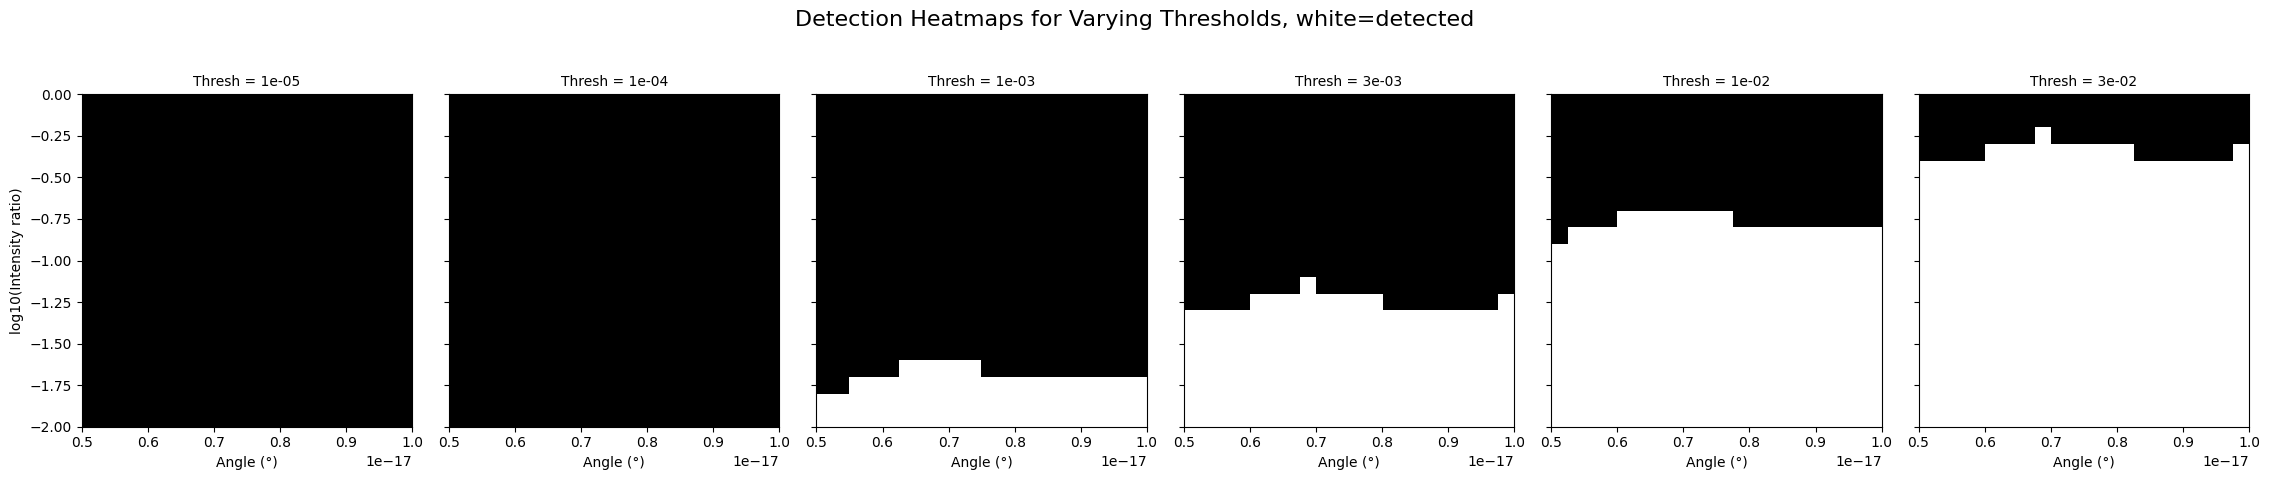

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# More thresholds to explore finer detection limits
thresholds = [1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2]

# Create subplots
fig, axs = plt.subplots(1, len(thresholds), figsize=(3.8 * len(thresholds), 5), sharey=True)

# Plot extent
extent = [
    np.rad2deg(angles[0]), np.rad2deg(angles[-1]),
    np.log10(ratios[0]), np.log10(ratios[-1])
]

# Colormap
cmap = plt.cm.binary

# Plot each heatmap
for idx, threshold in enumerate(thresholds):
    ax = axs[idx]
    detection_map = (max_diff_map > threshold).astype(int)

    im = ax.imshow(
        detection_map, aspect='auto', extent=extent, origin='lower',
        cmap=cmap, vmin=0, vmax=1
    )

    ax.set_title(f"Thresh = {threshold:.0e}", fontsize=10)
    ax.set_xlabel("Angle (°)")
    if idx == 0:
        ax.set_ylabel("log10(Intensity ratio)")

# Add colorbar on the far right
# cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01, shrink=0.8)
# cbar.set_label("Detection (1 = yes, 0 = no)")

# Global title and layout
plt.suptitle("Detection Heatmaps for Varying Thresholds, white=detected", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Both the star and the planet are modeled as gaussian beams with different sizes. The planet is located outside of the star's disk, to be able to be detected. The angle used is modeled as the angle between the star and the planet, as seen from the observer. The values used correpond approximately to values that we could find for proxima centauri, the closest star to us, so that the simulation is a bit more "realistic". Both parameters play a role but the most important one here is the relative intensity between the two bodies.

Parameters that also have a huge importance for such a detection are the quality of the detector and the noise from the environment. This can be seen with the different thresholds on the figure above. We must also take into account 


Here is an example of the processing steps, more an be seen by setting plot=True when calling coronagraph()


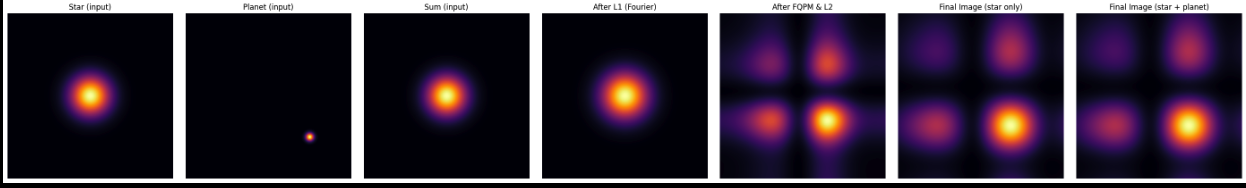